In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
#print(os.listdir("C:/temp/DogsandCats/train"))

In [2]:
# define image related constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 #TGB channels

In [4]:
filenames = os.listdir("C:/temp/DogsandCats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
print(df.head())

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0


<AxesSubplot:>

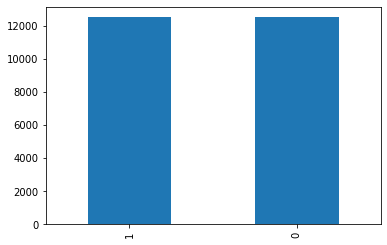

In [5]:
# see total in counts
df['category'].value_counts().plot.bar()

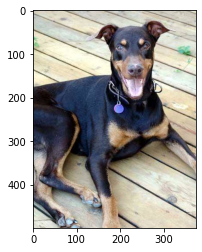

In [13]:
# check a sample image
sample = random.choice(filenames)
image = load_img("C:/temp/DogsandCats/train/"+sample)
plt.imshow(image)

In [9]:
#build model with keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [14]:
model = Sequential()

model.add(Conv2D(32, (3 , 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2))) # default is (2,2)
model.add(Dropout(rate=0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2))) # default is (2,2)
model.add(Dropout(rate=0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2))) # default is (2,2)
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(units=2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [15]:
# callbacks - early stop & learning rate reduction
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [35]:
earlystop = EarlyStopping(patience=10)
learn_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.0001)
callbacks = [earlystop, learn_rate_reduction]

<AxesSubplot:>

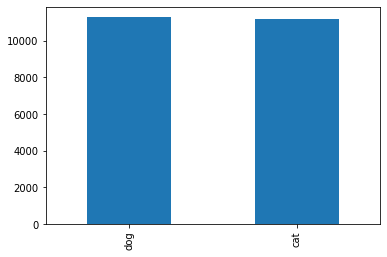

In [20]:
# data preparation
df["category"] = df["category"].replace({0:'cat', 1:'dog'}) # dog is target
df_train, df_test = train_test_split(df, test_size=0.1, random_state = 42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train["category"].value_counts().plot.bar()

<AxesSubplot:>

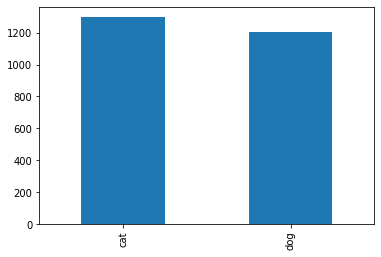

In [21]:
df_test["category"].value_counts().plot.bar()

In [23]:
total_train = df_train.shape[0]
total_test = df_test.shape[0]
batch_size = 15

In [24]:
# image data argumentation
# training generator
train_datagen = ImageDataGenerator(
    rotation_range= 15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [26]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory="C:/temp/DogsandCats/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [28]:
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory="C:/temp/DogsandCats/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


In [29]:
# check performance of data argumentation
df_example = df_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example,
    directory="C:/temp/DogsandCats/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


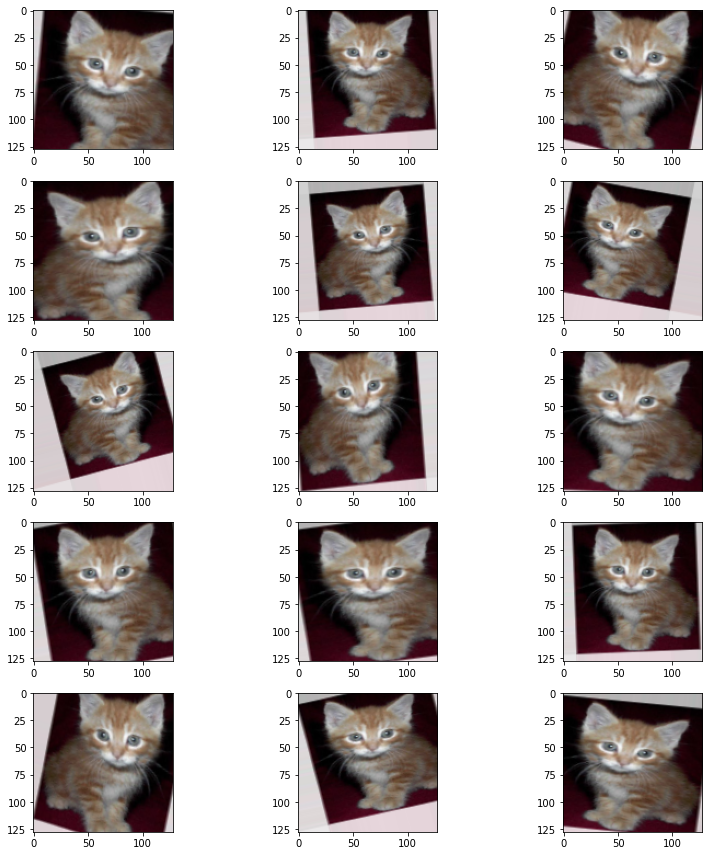

In [30]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [34]:
# fit model
epochs = 3 if FAST_RUN else 50 # 1 epoch meaning "one pass over the entire database" 
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=total_test//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
# created new branch of 15

Epoch 1/50
1500/1500 [==============================] - 910s 607ms/step - loss: 0.7109 - accuracy: 0.6113 - val_loss: 0.8473 - val_accuracy: 0.5843
Epoch 2/50
  45/1500 [..............................] - ETA: 13:28 - loss: 0.6200 - accuracy: 0.644

KeyboardInterrupt: 

In [ ]:
# save trained model weights
model.save_weights("modelAug18.h5")

In [ ]:
# virtualize training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(history.history['loss'], color='b',label="Training loss")
ax1.plot(history.history['val_loss'], color='r',label="Testing loss")
ax1.set_xticks(np.arrange(1, epochs, 1))
ax1.set_yticks(np.arrange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b',label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Testing accuracy")
ax2.set_xticks(np.arrange(1, epochs, 1))
#ax2.set_yticks(np.arrange(0, 1, 0.1)) # accuracy should be between 0 to 1 but not always true

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# prepare independent valdiation data
filenames_val = os.listdir("C:/temp/DogsandCats/test1")
df_val = pd.DataFrame({
    'filename': filenames_val
})
n_samples = df_val.shape[0]

In [ ]:
# testing generator
val_gen = ImageDataGenerator(rescale=1./255)
val_generator = val_gen.flow_from_dataframe(
    df_val,
    directory="C:/temp/DogsandCats/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# prediction on independent validation sample
predict = model.predict_generator(val_generator, step=np.ceil(n_samples/batch_size))

In [ ]:
df_val['category'] = np.argmax(predictm axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
print(label_map)
df_val['category'] = df_val['category'].replace(label_map)
df_val['category'] = df_val['category'].replace({'cat':0, 'dog':1})

In [ ]:
# visualize prediction
df_val['category'].value_counts().plot.bar()

In [ ]:
sample_val = df_val.head(18)
plt.figure(figsize=(12,24))
for index, row in sample_val.iterrows():
    filename = row['filename']
    catefory = row['category']
    img = load_img("C:/temp/DogsandCats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6,3,index+1)
    plt.imgshow(img)
    plt.xlabel(filename+'('+"{}".format(category)+')')
plt.tight_layout()
plt.show

In [ ]:
# output to csv/excel file for checking
df_output = df_val.copy()
df_output['id'] = df_output['filename'].str.split('.').str[0]
df_output['label'] = dfoutput['category']
df_output.drop(['filename','category'],axis=1,inplace=True)
df_output.to_csv('predicted_output.csv',index=False)